In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Import data as a dataframe

freestyle = pd.read_csv('speedrun_data.csv')

#Reorganize indexes
# speed_df.set_index(['Star Rating','Monster Name'],inplace=True)

freestyle.head()

,Star Rating,Monster Name,Quest,Runner,Time,Weapon,Platform,Ruleset
0,6,Alatreon,The Evening Star,DEVA,"01'55""11",Heavy Bowgun,PC,Freestyle
1,6,Alatreon,The Evening Star,DEVA,"02'05""13",Heavy Bowgun,PC,Freestyle
2,6,Alatreon,The Evening Star,Jackdaw갈까마귀,"02'24""56",Heavy Bowgun,PC,Freestyle
3,6,Alatreon,The Evening Star,Jackdaw갈까마귀,"02'30""96",Heavy Bowgun,PC,Freestyle
4,6,Alatreon,Dawn of the Death Star,Jackdaw갈까마귀,"02'44""40",Heavy Bowgun,PC,Freestyle


In [3]:
# Filter out 'repeat runs'
# 'Repeat run': run on the same monster, same quest, by the same runner with the same weapon, but different times.
# Keep only the fastest run

freestyle = freestyle.drop_duplicates(['Monster Name','Quest','Runner','Weapon'],keep='first') #Already sorted by time,
                                                                                               #first time = fastest!


In [4]:
#Function to convert the time field to seconds
def to_seconds(time_string):
    
    #Get minutes, seconds and centi seconds from string
    minutes = int(time_string[0:2])
    seconds = int(time_string[3:5])
    cents = int(time_string[6:])
    
    #Return total in seconds
    return 60*minutes+seconds+cents/100
    
#Add Time (s) column
freestyle.insert(5, 'Time (s)', freestyle['Time'].apply(to_seconds))

In [5]:
#Convert Star Rating to string (discrete values!)
freestyle['Star Rating']=freestyle['Star Rating'].apply(str)

In [6]:
#Abbreviate weapon names

weapon_dict = {'Great Sword':'GS',
               'Long Sword':'LS',
               'Sword And Shield':'SnS',
               'Dual Blades':'DB',
               'Lance':'Lance',
               'Gunlance':'GL',
               'Hammer':'Hammer',
               'Hunting Horn':'HH',
               'Switch Axe':'SA',
               'Charge Blade':'CB',
               'Insect Glaive':'IG',
               'Heavy Bowgun':'HBG',
               'Light Bowgun':'LBG',
               'Bow':'Bow'    
               }

#Apply dict to weapons column
freestyle['Weapon']=freestyle['Weapon'].apply(lambda x: weapon_dict[x])

In [7]:
# Sort dataframe by, in order: Star Rating, Monster Name, Quest, and Time
freestyle = freestyle.sort_values(['Star Rating','Monster Name','Time (s)','Quest'],ascending=[False,True,True,True])

#Fix indexes
freestyle = freestyle.reset_index(drop=True)

In [8]:
# Function to generate rankings by quest or monster
def general_rank(speed_df,rank_by_column='Quest',time_column='Time (s)',sort=True):
    

    # Sort dataframe accordingly
    if sort:
        speed_df = speed_df.sort_values([rank_by_column,time_column],ascending=True)
    
    #Start with an empty list
    ranking=[]
    
    #Get a list of all items to iterate through
    rank_by_list = speed_df[rank_by_column].unique()
    
    #Iterate through all quests or monsters
    for item in rank_by_list: 
        #First entry is always rank 1
        rank = 1; 

        #Get slice of the input df corresponding to the quest name
        df_slice = speed_df[speed_df[rank_by_column]==item]

        #Append rankings to the list, for the length of the slice
        for index, row in df_slice.iterrows():
            ranking.append(rank)
            rank += 1

        #Reset rank count for next iteration
        rank=1;
    
    #Create DataFrame to return
    rank_df = pd.DataFrame(data=ranking,index=speed_df.index)
    
    #If sorted previously, return to old sorting before returning
    if sort:
        rank_df = rank_df.sort_index()

    return rank_df

In [9]:
# Function to generate rankings by quest or monster, separating each weapon
def weapon_rank(speed_df,rank_by_column='Quest',weapon_column='Weapon',time_column='Time (s)',sort=True):
    
    #Sort dataframe accordingly
    if sort:
        speed_df = speed_df.sort_values([rank_by_column,weapon_column,time_column],ascending=[True,True,True])
    
    #Start with empty list
    ranking=[] 
    
    #Get a list of all items to iterate through
    rank_by_list = speed_df[rank_by_column].unique()
    
    #Iterate through all quests or monsters
    for item in rank_by_list: 
        
        #Get slice of the input df corresponding to the quest name
        df_slice = speed_df[speed_df[rank_by_column]==item]
    
        #Get list of weapons with an entry for this quest/monster
        weapon_list = df_slice[weapon_column].unique()

        #Iterate through all weapons
        for weapon in weapon_list:
            #First entry is always rank 1
            rank = 1;     

            #Get subslice of slice_df corresponding to this weapon
            df_subslice = df_slice[df_slice[weapon_column]==weapon]

            #Append rankings to the list, for the length of the slice
            for subindex, subrow in df_subslice.iterrows():
                ranking.append(rank)
                rank += 1

            #Reset rank count for next iteration
            rank=1;
    
    #Create DataFrame to return
    rank_df = pd.DataFrame(data=ranking,index=speed_df.index)
    
    #If sorted previously, return to old sorting before returning
    if sort:
        rank_df = rank_df.sort_index()

    return rank_df

In [10]:
# Separate TA runs. Note that Freestyle runs also encompass TA runs (ie a TA run is also a Freestyle run, but a Freestyle run
# not be a TA run)

ta = freestyle[freestyle['Ruleset']=='TA Rules'].copy()
ta = ta.drop('Ruleset',axis=1) #Drop Ruleset column as it is redundant

In [11]:
#Rank by monster
freestyle['Monster/General'] = general_rank(freestyle[['Monster Name','Time (s)']],rank_by_column='Monster Name')
ta['Monster/General'] = general_rank(ta[['Monster Name','Time (s)']],rank_by_column='Monster Name')

#Rank by quest
freestyle['Quest/General'] = general_rank(freestyle[['Quest','Time (s)']],rank_by_column='Quest')
ta['Quest/General'] = general_rank(ta[['Quest','Time (s)']],rank_by_column='Quest')

In [12]:
#Rank by monster and weapon type
freestyle['Monster/Weapon'] = weapon_rank(freestyle[['Monster Name','Weapon','Time (s)']],
                                          rank_by_column='Monster Name',weapon_column='Weapon')
ta['Monster/Weapon'] = weapon_rank(ta[['Monster Name','Weapon','Time (s)']],
                                          rank_by_column='Monster Name',weapon_column='Weapon')

#Rank by quest and weapon type
freestyle['Quest/Weapon'] = weapon_rank(freestyle[['Quest','Weapon','Time (s)']],
                                        rank_by_column='Quest',weapon_column='Weapon')
ta['Quest/Weapon'] = weapon_rank(ta[['Quest','Weapon','Time (s)']],
                                        rank_by_column='Quest',weapon_column='Weapon')

In [26]:
#Very early analysis: just get average TOP clear time by weapons/monsters

#Pick out the top freestyle and TA runs
avg_freestyle = freestyle[freestyle['Monster/Weapon']==1]
avg_ta = ta[ta['Monster/Weapon']==1]

#Group by weapon type and get the mean values
avg_freestyle = avg_freestyle.groupby('Weapon').mean().reset_index()
avg_ta = avg_ta.groupby('Weapon').mean().reset_index()

#Sort weapons
avg_freestyle = avg_freestyle.sort_values('Time (s)',ascending=True)
avg_ta = avg_ta.sort_values('Time (s)',ascending=True)

In [30]:
avg_freestyle

,Weapon,Time (s),Monster/General,Quest/General,Monster/Weapon,Quest/Weapon
5,HBG,115.684615,1.784615,1.630769,1.0,1.0
0,Bow,141.990727,7.454545,5.945455,1.0,1.0
4,GS,146.715172,11.034483,8.982759,1.0,1.0
2,DB,160.144561,16.245614,13.508772,1.0,1.0
12,SA,166.764667,16.933333,14.366667,1.0,1.0
9,LBG,174.870566,15.037736,12.037736,1.0,1.0
1,CB,178.079811,20.943396,17.150943,1.0,1.0
3,GL,186.566939,33.387755,29.061224,1.0,1.0
7,Hammer,189.370000,25.865385,21.269231,1.0,1.0
13,SnS,194.158511,22.276596,19.340426,1.0,1.0


<AxesSubplot:xlabel='Weapon', ylabel='Time (s)'>

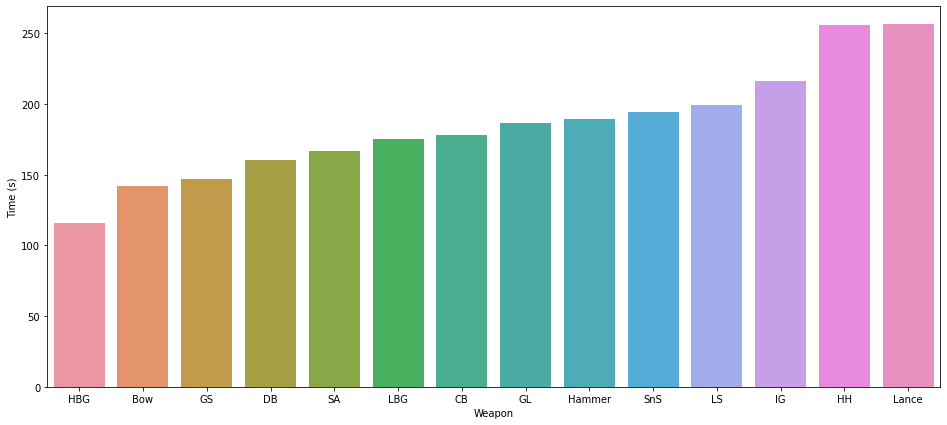

In [28]:
#Plot average freestyle times
plt.figure(figsize=(16,7))
sns.barplot(x='Weapon',y='Time (s)',data=avg_freestyle)

<AxesSubplot:xlabel='Weapon', ylabel='Time (s)'>

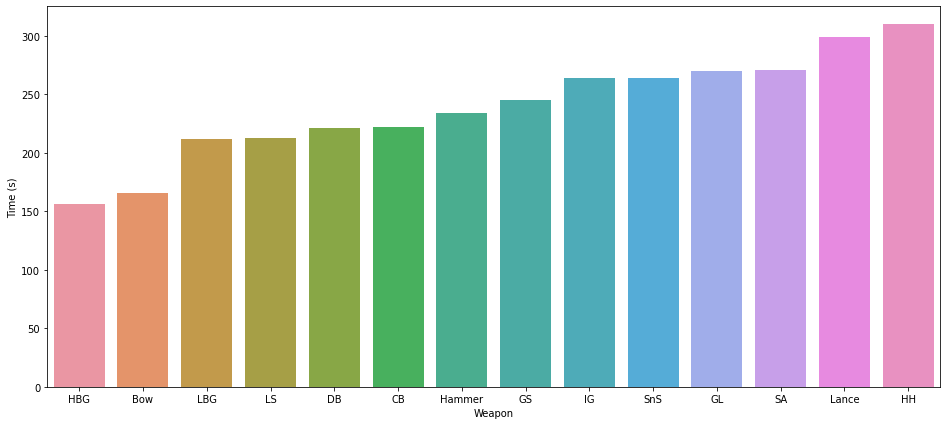

In [29]:
#Plot average TA times
plt.figure(figsize=(16,7))
sns.barplot(x='Weapon',y='Time (s)',data=avg_ta)